# Collaborative-based recommender system using Graph Neural Networks

Recommender systems are everywhere: on major platforms like Amazon, Netflix, and Spotify, offering suggestions that range from fantastic to underwhelming, and sometimes even amusing. While they make it easier for us to discover new things to buy, watch, or listen to, it's the companies that gain the most from their use.

Recommender systems primarily use two approaches: content-based filtering and collaborative filtering.

- **Content-Based Filtering**:
This approach recommends items by analyzing the features of the items themselves (e.g., genre, brand) and matching them to a user’s preferences or past interactions. It suggests items similar to those the user has previously engaged with, focusing on item characteristics rather than other users’ behaviors.

- **Collaborative Filtering**:
Collaborative filtering generates recommendations by leveraging user behavior. It identifies patterns based on how users interact with items and makes recommendations either by finding similar users (user-based) or by finding similar items based on user preferences (item-based). It relies on the assumption that users with similar past behavior will like similar items.

Both methods are essential in building personalized recommendation systems, and they are often combined for better results.

In this tutorial, we use the "Collaborative Filtering" approach to implement a "book recommender system". 

The code is borrowed from https://github.com/PacktPublishing/Hands-On-Graph-Neural-Networks-Using-Python/blob/main/Chapter17/chapter17.ipynb

To implement a book recommender system, we use the Book-Crossing dataset which contains book ratings from 278,858 users of the BookCrossing community (www.bookcrossing.com). These ratings are explicit feedback (ratings from 1 to 10), totaling 1,149,780 ratings across 271,379 books. The dataset was gathered by Cai-Nicolas Ziegler during a four-week data collection in August and September 2004. We will utilize the Book-Crossing dataset to develop a book recommendation system.


The dataset consists of three files, which we will load sequentially as tabular data.

- First, the user-rating file contains explicit feedback, where each entry associates a user ID with a specific book identified by its ISBN. Most of the ratings are zero.

In [40]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
from torch import nn, optim, Tensor
from torch_geometric.utils import structured_negative_sampling
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn import LGConv
import tqdm as notebook_tqdm


df = pd.read_csv('BX-Book-Ratings.csv', sep=';', encoding='latin-1')
df.head()


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


- Second file is the user attribute file, which contains the age and location of each user.

In [41]:
users = pd.read_csv('BX-Users.csv', sep=';', encoding='latin-1')
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


- Third file is the item (book) attribute file, containing features for each book such as the title, author, year of publication, and more.

In [42]:
books = pd.read_csv('BX-Books.csv', sep=';', encoding='latin-1', on_bad_lines='skip')
books.head()

C:\Users\Asus\AppData\Local\Temp\ipykernel_12472\2192118833.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('BX-Books.csv', sep=';', encoding='latin-1', on_bad_lines='skip')


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


The next step is to build an **undirected, unweighted, bipartite** graph based on the user-book interaction:

- A **bipartite** graph is a graph where the set of nodes can be divided into two distinct groups, such that no two nodes within the same group are connected by an edge. All edges only link nodes from one group to nodes in the other group. 
A user-item graph is well-modeled by a bipartite graph because users and items naturally form two distinct sets. In this graph, edges represent interactions (e.g., purchases, ratings) between users and items, with no connections between nodes within the same set (e.g., no user-user or item-item edges), aligning perfectly with the structure of a bipartite graph.

<center><img src="images/user_item.png" width="300"/></center>

- The graph is undirected and **unweighted**, with *an edge placed between a user and a corresponding book only if the rating is above eight*. 
In this graph, each edge represents a significant user-book interaction based on ratings. Specifically, an edge is added between a user and a book only when the user has given a rating higher than eight, indicating a strong preference. The graph is undirected, meaning the relationship is mutual (the user is connected to the book, and vice versa), and unweighted, so all connections are treated equally, regardless of how much the rating exceeds eight. This simplifies the model by focusing only on high ratings, disregarding the exact rating value above this threshold.

In [43]:
# Preprocessing: filtering user-book interactions to only include valid users and books found in related datasets "books" & "users"
df = df.loc[df['ISBN'].isin(books['ISBN'].unique()) & df['User-ID'].isin(users['User-ID'].unique())]

# Keep the 100k high ratings for faster computation and training
df = df[df['Book-Rating'] >= 8].iloc[:100000]

# Create mappings
user_mapping = {userid: i for i, userid in enumerate(df['User-ID'].unique())}
item_mapping = {isbn: i for i, isbn in enumerate(df['ISBN'].unique())}

# Count users and items
num_users = len(user_mapping)
num_items = len(item_mapping)
num_total = num_users + num_items
# Build the adjacency matrix based on user ratings
user_ids = torch.LongTensor([user_mapping[i] for i in df['User-ID']])
item_ids = torch.LongTensor([item_mapping[i] for i in df['ISBN']])
edge_index = torch.stack((user_ids, item_ids))

Next, we split the edges into 80% train, 10% validation and 10% test.

In [44]:
# Create training, validation, and test adjacency matrices
train_index, test_index = train_test_split(range(len(df)), test_size=0.2, random_state=0)
val_index, test_index = train_test_split(test_index, test_size=0.5, random_state=0)

train_edge_index = edge_index[:, train_index]
val_edge_index = edge_index[:, val_index]
test_edge_index = edge_index[:, test_index]

Now, we build a simple LightGCN network to compute the embeddings of the users/items based on the graph structure:

In [45]:

def sample_mini_batch(edge_index):
    # Generate BATCH_SIZE random indices
    index = np.random.choice(range(edge_index.shape[1]), size=BATCH_SIZE)

    # Generate negative sample indices
    edge_index = structured_negative_sampling(edge_index)
    edge_index = torch.stack(edge_index, dim=0)
    
    user_index = edge_index[0, index]
    pos_item_index = edge_index[1, index]
    neg_item_index = edge_index[2, index]
    
    return user_index, pos_item_index, neg_item_index

class LightGCN(nn.Module):
    def __init__(self, num_users, num_items, num_layers=4, dim_h=64):
        super().__init__()
        
        self.num_users = num_users
        self.num_items = num_items
        self.num_layers = num_layers
        self.emb_users = nn.Embedding(num_embeddings=self.num_users, embedding_dim=dim_h)
        self.emb_items = nn.Embedding(num_embeddings=self.num_items, embedding_dim=dim_h)

        self.convs = nn.ModuleList(LGConv() for _ in range(num_layers))

        nn.init.normal_(self.emb_users.weight, std=0.01)
        nn.init.normal_(self.emb_items.weight, std=0.01)

    def forward(self, edge_index):
        emb = torch.cat([self.emb_users.weight, self.emb_items.weight])
        embs = [emb]

        for conv in self.convs:
            emb = conv(x=emb, edge_index=edge_index)
            embs.append(emb)

        emb_final = 1/(self.num_layers+1) * torch.mean(torch.stack(embs, dim=1), dim=1)

        emb_users_final, emb_items_final = torch.split(emb_final, [self.num_users, self.num_items])

        return emb_users_final, self.emb_users.weight, emb_items_final, self.emb_items.weight

In [46]:
def bpr_loss(emb_users_final, emb_users, emb_pos_items_final, emb_pos_items, emb_neg_items_final, emb_neg_items):
    reg_loss = LAMBDA * (emb_users.norm().pow(2) +
                        emb_pos_items.norm().pow(2) +
                        emb_neg_items.norm().pow(2))

    pos_ratings = torch.mul(emb_users_final, emb_pos_items_final).sum(dim=-1)
    neg_ratings = torch.mul(emb_users_final, emb_neg_items_final).sum(dim=-1)

    bpr_loss = torch.mean(torch.nn.functional.softplus(pos_ratings - neg_ratings))
    # bpr_loss = torch.mean(torch.nn.functional.logsigmoid(pos_ratings - neg_ratings))

    return -bpr_loss + reg_loss
def get_user_items(edge_index):
    user_items = dict()
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_items:
            user_items[user] = []
        user_items[user].append(item)
    return user_items
def compute_recall_at_k(items_ground_truth, items_predicted):
    num_correct_pred = np.sum(items_predicted, axis=1)
    num_total_pred = np.array([len(items_ground_truth[i]) for i in range(len(items_ground_truth))])

    recall = np.mean(num_correct_pred / num_total_pred)

    return recall
def compute_ndcg_at_k(items_ground_truth, items_predicted):
    test_matrix = np.zeros((len(items_predicted), K))

    for i, items in enumerate(items_ground_truth):
        length = min(len(items), K)
        test_matrix[i, :length] = 1
    
    max_r = test_matrix
    idcg = np.sum(max_r * 1. / np.log2(np.arange(2, K + 2)), axis=1)
    dcg = items_predicted * (1. / np.log2(np.arange(2, K + 2)))
    dcg = np.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[np.isnan(ndcg)] = 0.
    
    return np.mean(ndcg)
# wrapper function to get evaluation metrics
def get_metrics(model, edge_index, exclude_edge_indices):

    ratings = torch.matmul(model.emb_users.weight, model.emb_items.weight.T)

    for exclude_edge_index in exclude_edge_indices:
        user_pos_items = get_user_items(exclude_edge_index)
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)
        ratings[exclude_users, exclude_items] = -1024

    # get the top k recommended items for each user
    _, top_K_items = torch.topk(ratings, k=K)

    # get all unique users in evaluated split
    users = edge_index[0].unique()

    test_user_pos_items = get_user_items(edge_index)

    # convert test user pos items dictionary into a list
    test_user_pos_items_list = [test_user_pos_items[user.item()] for user in users]

    # determine the correctness of topk predictions
    items_predicted = []
    for user in users:
        ground_truth_items = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
        items_predicted.append(label)

    recall = compute_recall_at_k(test_user_pos_items_list, items_predicted)
    ndcg = compute_ndcg_at_k(test_user_pos_items_list, items_predicted)

    return recall, ndcg
# wrapper function to evaluate model
def test(model, edge_index, exclude_edge_indices):
    emb_users_final, emb_users, emb_items_final, emb_items = model.forward(edge_index)
    user_indices, pos_item_indices, neg_item_indices = structured_negative_sampling(edge_index, contains_neg_self_loops=False)

    emb_users_final, emb_users = emb_users_final[user_indices], emb_users[user_indices]

    emb_pos_items_final, emb_pos_items = emb_items_final[pos_item_indices], emb_items[pos_item_indices]
    emb_neg_items_final, emb_neg_items = emb_items_final[neg_item_indices], emb_items[neg_item_indices]

    loss = bpr_loss(emb_users_final, emb_users, emb_pos_items_final, emb_pos_items, emb_neg_items_final, emb_neg_items).item()

    recall, ndcg = get_metrics(model, edge_index, exclude_edge_indices)

    return loss, recall, ndcg
K = 20
LAMBDA = 1e-6
BATCH_SIZE = 1024
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LightGCN(num_users, num_items)
model = model.to(device)
edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
val_edge_index = val_edge_index.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

n_batch = int(len(train_index)/BATCH_SIZE)

for epoch in range(31):
    model.train()

    for _ in range(n_batch):
        optimizer.zero_grad()

        emb_users_final, emb_users, emb_items_final, emb_items = model.forward(train_edge_index)

        user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(train_edge_index)
        
        emb_users_final, emb_users = emb_users_final[user_indices], emb_users[user_indices]
        emb_pos_items_final, emb_pos_items = emb_items_final[pos_item_indices], emb_items[pos_item_indices]
        emb_neg_items_final, emb_neg_items = emb_items_final[neg_item_indices], emb_items[neg_item_indices]

        train_loss = bpr_loss(emb_users_final, emb_users, emb_pos_items_final, emb_pos_items, emb_neg_items_final, emb_neg_items)

        train_loss.backward()
        optimizer.step()

    if epoch % 5 == 0:
        model.eval()
        val_loss, recall, ndcg = test(model, val_edge_index, [train_edge_index])
        print(f"Epoch {epoch} | Train loss: {train_loss.item():.5f} | Val loss: {val_loss:.5f} | Val recall@{K}: {recall:.5f} | Val ndcg@{K}: {ndcg:.5f}")
test_loss, test_recall, test_ndcg = test(model, test_edge_index.to(device), [train_edge_index, val_edge_index])

print(f"Test loss: {test_loss:.5f} | Test recall@{K}: {test_recall:.5f} | Test ndcg@{K}: {test_ndcg:.5f}")



Epoch 0 | Train loss: -0.69336 | Val loss: -0.69255 | Val recall@20: 0.01050 | Val ndcg@20: 0.00563
Epoch 5 | Train loss: -0.73737 | Val loss: -0.63748 | Val recall@20: 0.01774 | Val ndcg@20: 0.00851
Epoch 10 | Train loss: -0.90949 | Val loss: -0.43255 | Val recall@20: 0.01799 | Val ndcg@20: 0.00857
Epoch 15 | Train loss: -1.42367 | Val loss: -0.04532 | Val recall@20: 0.01802 | Val ndcg@20: 0.00883
Epoch 20 | Train loss: -2.13285 | Val loss: 0.49631 | Val recall@20: 0.01724 | Val ndcg@20: 0.00840
Epoch 25 | Train loss: -3.16662 | Val loss: 1.15611 | Val recall@20: 0.01773 | Val ndcg@20: 0.00875
Epoch 30 | Train loss: -4.15604 | Val loss: 1.92077 | Val recall@20: 0.01784 | Val ndcg@20: 0.00883
Test loss: 1.89538 | Test recall@20: 0.01764 | Test ndcg@20: 0.00882


We have trained the model and now, we want to use this model to recommend books for a specific user:

Favorite books from user n°277427:
- The Da Vinci Code, by Dan Brown
- Into the Wild, by Jon Krakauer
- One for the Money (Stephanie Plum Novels (Paperback)), by Janet Evanovich

Recommended books for user n°277427
- The Lovely Bones: A Novel, by Alice Sebold
- The Red Tent (Bestselling Backlist), by Anita Diamant
- To Kill a Mockingbird, by Harper Lee
- Angels &amp; Demons, by Dan Brown
- Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)), by J. K. Rowling


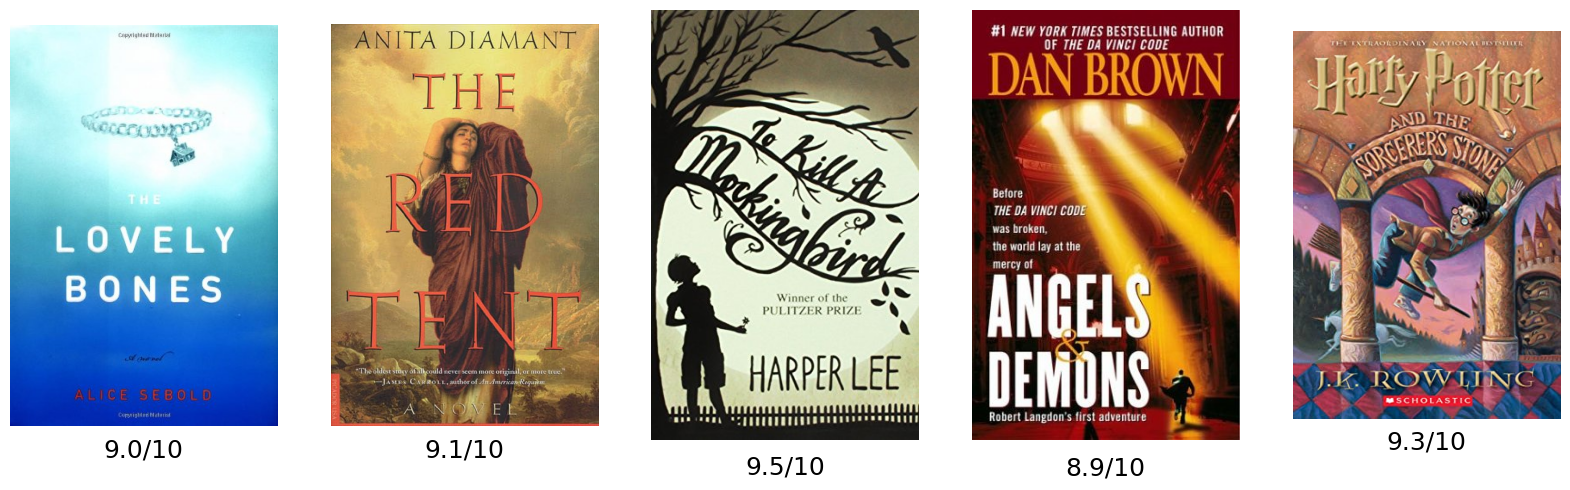

In [47]:
bookid_title = pd.Series(books['Book-Title'].values, index=books.ISBN).to_dict()
bookid_author = pd.Series(books['Book-Author'].values, index=books.ISBN).to_dict()
user_pos_items = get_user_items(edge_index)
from PIL import Image
import requests

def recommend(user_id, num_recs):
    user = user_mapping[user_id]
    emb_user = model.emb_users.weight[user]
    ratings = model.emb_items.weight @ emb_user

    values, indices = torch.topk(ratings, k=100)

    ids = [index.cpu().item() for index in indices if index in user_pos_items[user]][:num_recs]
    item_isbns = [list(item_mapping.keys())[list(item_mapping.values()).index(book)] for book in ids]
    titles = [bookid_title[id] for id in item_isbns]
    authors = [bookid_author[id] for id in item_isbns]

    print(f'Favorite books from user n°{user_id}:')
    for i in range(len(item_isbns)):
        print(f'- {titles[i]}, by {authors[i]}')

    ids = [index.cpu().item() for index in indices if index not in user_pos_items[user]][:num_recs]
    item_isbns = [list(item_mapping.keys())[list(item_mapping.values()).index(book)] for book in ids]
    titles = [bookid_title[id] for id in item_isbns]
    authors = [bookid_author[id] for id in item_isbns]

    print(f'\nRecommended books for user n°{user_id}')
    for i in range(num_recs):
        print(f'- {titles[i]}, by {authors[i]}')

    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
    fig, axs = plt.subplots(1, num_recs, figsize=(20,6))
    fig.patch.set_alpha(0)
    for i, title in enumerate(titles):
        url = books.loc[books['Book-Title'] == title]['Image-URL-L'][:1].values[0]
        img = Image.open(requests.get(url, stream=True, headers=headers).raw)
        rating = df.loc[df['ISBN'] == books.loc[books['Book-Title'] == title]['ISBN'][:1].values[0]]['Book-Rating'].mean()
        axs[i].axis("off")
        axs[i].imshow(img)
        axs[i].set_title(f'{rating:.1f}/10', y=-0.1, fontsize=18)
recommend(277427, 5)